# Logistic Regression Model Notebook

```md
@author: miguelrocha
(Adapted by: Grupo 03)
```

In [1]:
# Notebook Imports
import numpy as np

from models.logistic_regression_model import LogisticRegression, classify_texts, hyperparameter_tuning
from helpers.dataset import Dataset
from helpers.model import save_model
from helpers.metrics import confusion_matrix, balanced_accuracy, precision_recall_f1
from helpers.enums import ModelRunMode

In [2]:
# Model run mode
# Options: 
#   ModelRunMode.TRAIN.value            (Train the model)
#   ModelRunMode.CLASSIFY.value         (Classify data)
mode = ModelRunMode.TRAIN.value

In [3]:
# Parameters cell
if mode == ModelRunMode.TRAIN.value:
    # Train mode
    input_csv = "../tarefa_1/clean_input_datasets/gpt_vs_human_data_set_inputs.csv"              # CSV for training input (ID, Text)
    output_csv = "../tarefa_1/clean_output_datasets/gpt_vs_human_data_set_outputs.csv"           # CSV for training output (ID, Label)
    model_prefix = "logreg_model"                                                   # Prefix for saving the model files
    test_size = 0.3                                                                 # Proportion of the dataset to use as test data
    regularization = True                                                           # Use L2 regularization approach
    lamda = 0.5                                                                     # Lambda for L2 regularization
    alpha = 0.001                                                                   # Learning rate for gradient descent
    iters = 40000                                                                   # Iterations for gradient descent
elif mode == ModelRunMode.CLASSIFY.value:
    # Classify mode
    input_csv = "../tarefa_1/clean_input_datasets/dataset1_inputs.csv"              # CSV for training input (ID, Text)
    output_csv = "../tarefa_1/classify_output_datasets/dataset1_outputs.csv"        # CSV for predictions output
    model_prefix = "logreg_model"                                                   # Prefix for loading the model files
else:
    print("The selected option is not valid. Options: \"train\" or \"classify\"!")
    SystemExit()

Train set has 2838 rows and 3768 columns
Test set has 1215 rows and 3768 columns

Starting hyperparameter tuning...
Iter=0, cost=0.6930949133
Iter=1000, cost=0.6461096017
Iter=2000, cost=0.6075681760
Iter=3000, cost=0.5750730105
Iter=4000, cost=0.5470184278
Iter=5000, cost=0.5223336791
Iter=6000, cost=0.5002940244
Iter=7000, cost=0.4803959115
Iter=8000, cost=0.4622780604
Iter=9000, cost=0.4456722851
alpha: 0.0001, lamda: 0, iters: 10000 -> Validation Accuracy: 0.9366
Iter=0, cost=0.6930949133
Iter=1000, cost=0.6461096017
Iter=2000, cost=0.6075681760
Iter=3000, cost=0.5750730105
Iter=4000, cost=0.5470184278
Iter=5000, cost=0.5223336791
Iter=6000, cost=0.5002940244
Iter=7000, cost=0.4803959115
Iter=8000, cost=0.4622780604
Iter=9000, cost=0.4456722851
Iter=10000, cost=0.4303728055
Iter=11000, cost=0.4162168948
Iter=12000, cost=0.4030724693
Iter=13000, cost=0.3908299595
Iter=14000, cost=0.3793968526
Iter=15000, cost=0.3686939262
Iter=16000, cost=0.3586525743
Iter=17000, cost=0.3492128521
I

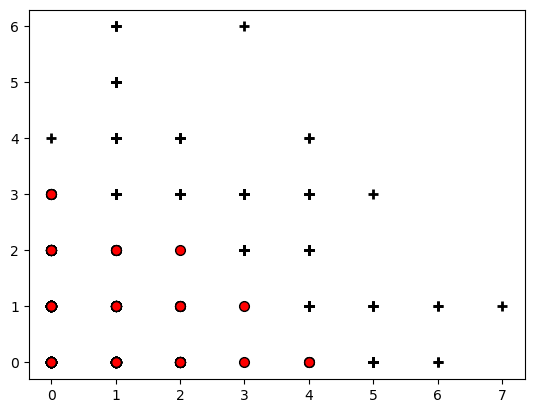

In [4]:
if mode == ModelRunMode.TRAIN.value:
    # Load Datasets
    X_train, y_train, X_test, y_test, vocab = Dataset.prepare_train_test_bow(input_csv=input_csv, output_csv=output_csv, test_size=test_size, max_vocab_size=None, min_freq=8)

    # Create Dataset objects for training and testing
    train_ds_full = Dataset(X=X_train, Y=y_train)
    test_ds = Dataset(X=X_test, Y=y_test)

    # Validate Train and Test dataset division
    print(f"Train set has {train_ds_full.nrows()} rows and {train_ds_full.ncols()} columns")
    print(f"Test set has {test_ds.nrows()} rows and {test_ds.ncols()} columns\n")

    # Split the full training data into training and validation sets
    n_train = train_ds_full.X.shape[0]
    indices = np.arange(n_train)
    np.random.shuffle(indices)
    split_idx = int(0.8 * n_train)
    train_idx = indices[:split_idx]
    val_idx = indices[split_idx:]
    train_ds = Dataset(X=train_ds_full.X[train_idx], Y=train_ds_full.Y[train_idx])
    val_ds = Dataset(X=train_ds_full.X[val_idx], Y=train_ds_full.Y[val_idx])

    # Define hyperparameter grids
    alphas = [0.0001, 0.001, 0.01, 0.1]
    lambdas = [0, 0.01, 0.1, 0.5, 1.0, 1.5]
    iters_list = [10000, 20000, 40000, 80000]

    print("Starting hyperparameter tuning...")
    best_params, best_acc, results = hyperparameter_tuning(train_ds, val_ds, alphas, lambdas, iters_list)
    print("\nBest hyperparameters:", best_params)
    print("Best validation accuracy:", best_acc)

    # Retrain model on full training data with best hyperparameters
    final_model = LogisticRegression(train_ds_full, regularization=(best_params["lamda"] > 0), lamda=best_params["lamda"])
    final_model.gradientDescent(alpha=best_params["alpha"], iters=best_params["iters"])

    # Save the model
    save_model(final_model.theta, vocab, model_prefix)
    print(f"Model saved with prefix {model_prefix}")

    # Evaluate on test set
    ones_test = np.ones((test_ds.X.shape[0], 1))
    X_test_bias = np.hstack((ones_test, test_ds.X))
    test_acc = final_model.accuracy(X_test_bias, test_ds.Y)
    print(f"\nTest accuracy with best hyperparameters: {test_acc:.4f}")

    preds = final_model.predictMany(X_test_bias)
    TP, FP, TN, FN = confusion_matrix(y_test, preds)
    prec, rec, f1 = precision_recall_f1(y_test, preds)
    bal_acc = balanced_accuracy(y_test, preds)

    print("Confusion Matrix: TP={}, FP={}, TN={}, FN={}".format(TP, FP, TN, FN))
    print("Precision = {:.4f}, Recall = {:.4f}, F1 = {:.4f}".format(prec, rec, f1))
    print("Balanced Accuracy = {:.4f}".format(bal_acc))
    final_model.plotModel()

if mode == ModelRunMode.CLASSIFY.value:
    classify_texts(input_csv, output_csv, model_prefix=model_prefix)